In [773]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [774]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if row.our_data == 0:
            if(np.floor(row.SessionID/100).astype(int) == user):
                aux.append(1)
            else:
                aux.append(0)
        else:
            if 'Diego' in row.SessionID and user == 'Diego':
                aux.append(1)
            elif 'Toto' in row.SessionID and user == 'Toto':
                aux.append(1)
            elif (('Jo' in row.SessionID) or ('jo' in row.SessionID)) and user == 'Jo':
                aux.append(1)
            else:
                aux.append(0)
    df['target'] = aux

In [775]:
def separateIntoTrainAndTest(df, test_sessions = []):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = test_sessions
    for i in range(10):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [776]:
def getOurDataUsers(row):
    if 'Diego' in row.SessionID :
        return('Diego')
    elif 'Toto' in row.SessionID:
        return('Toto')
    elif ('Jo' in row.SessionID) or ('jo' in row.SessionID):
        return('Jo')

In [777]:
file_name = '../aggregated_features'
our_data_file_name = '../our_data_aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')
our_data_df = pd.read_csv('./' + our_data_file_name + '.csv')
df['our_data'] = 0
our_data_df['our_data'] = 1

In [778]:
users = (np.floor(df.SessionID/100).astype(int)).unique()
our_data_users = our_data_df.apply(getOurDataUsers,axis=1)

In [779]:
df = df.append(our_data_df,ignore_index=True)

In [780]:
#user = random.choice(users)
user = 'Toto'
makeUserTarget(df, user)

In [781]:
to_drop =  ['our_data','Contact_size_mean','Contact_size_std'] 

In [782]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=4, random_state=31, colsample_bytree=0.5, colsample_bylevel=0.5, learning_rate=0.2, subsample=0.9)
#clf = RandomForestClassifier()

In [783]:
df_train, df_test = separateIntoTrainAndTest(df,test_sessions=['Jo1','jo3','jo2'])

In [784]:
df_train = df_train.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)
df_test = df_test.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [785]:
x_train, y_train = df_train.drop("target", axis=1), df_train["target"]

In [786]:
clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [787]:
i_pred_proba = clf.predict_proba(x_train)

In [788]:
auc = roc_auc_score(y_train, i_pred_proba[:, 1])
print(auc)

1.0


In [789]:
x_test, y_test = df_test.drop("target", axis=1), df_test["target"]

In [790]:
predict = clf.predict_proba(x_test)

In [791]:
df_predict = pd.DataFrame(clf.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)

In [792]:
df_socorro = df_predict.merge(df_test[['target']], right_index=True, left_index=True)

In [793]:
df_socorro[df_socorro.target == 0].mean()

prob      0.00346
target    0.00000
dtype: float64

In [794]:
df_socorro[df_socorro.target == 0].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
21871908,132.521327,0.000124,0
24825217,111.931937,0.000011,0
36628622,47.372340,0.000005,0
47276106,63.733871,0.000004,0
55635717,35.771429,0.000005,0
71786814,34.276923,0.000004,0
76381307,78.879195,0.000003,0
77707809,46.296703,0.000004,0
85640112,95.753086,0.000009,0


In [795]:
df_socorro[df_socorro.target == 1].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Toto5,25.0,0.326778,1


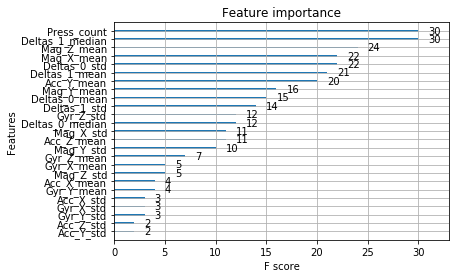

In [796]:
xgb.plot_importance(clf)
plt.figure()